# FunG: Modelagem de distribuição de famílias de Fungos.



 A proposta do projeto é elaborar um modelo preditivo com dados sobre espécies de fungos nativos do Brasil para determinar a família predominante de fungos em uma determinada região. Esse tipo de análise pode ser útil para fins comerciais, dado que fungos apresentam uma gama de aplicações medicinais, culinárias, entre outras. Além disso, pode auxiliar em estudos de biogeografia, fornecendo insights sobre como as condições do ambiente culmina na ocorrência e predominância dessas espécies. Como nosso *target* é uma classe, usaremos as métricas disponíveis no relatório de métricas (`classification_report`) do `sklearn.metrics`.

**ETAPAS**

1. Pré-processamento 
2. Treinamento dos modelos:<br>
    2.1. Baseline <br>
    2.2. k-Vizinhos Próximos <br>
    2.3. Floresta Aleatória <br>
    2.4. Naive Bayes <br>
3. Discussão dos resultados
4. Referências

### Importação e pre-processamento dos dados

**Importação e adaptação do dataset**<br>
Nessa etapa, estamos importando e adequando o dataset a nossas necessidades. O dataset utilizado será da Coleção de Fungos do Herbário SP, que possui cerca de 45 mil exemplares de fungos pertencentes principalmente ao grupo dos basidiomicetos e fungos liquenizados do estado de São Paulo. Esse conjunto de dados foi encontrado no GBIF, e inclui muitas colunas sobre os catalogadores dos exemplares, mas, para nós, as colunas de relevância serão as seguintes:

*Atributos categóricos:*<br>

- `municipality`: município que o fungo foi encontrado.

*Atributos numéricos:*<br>

- `decimalLatitude`: latitude que o fungo foi encontrado em decimais.
- `decimalLongitude`: longitude que o fungo foi encontrado em decimais.
- `meanElevationInMeters`: média das colunas originais `minimumElevationInMeters` e `maximumElevationInMeters`, que nos dirá a altura média que o fungo pode ser encontrado.

*Target*:
- `family`: família a que o fungo pertence

In [1]:
import pandas as pd
import seaborn as sns

df = pd.read_excel('dados_fungos.xlsx')
df.columns

Index(['id', 'type', 'modified', 'language', 'license', 'rightsHolder',
       'institutionCode', 'collectionCode', 'datasetName',
       'ownerInstitutionCode', 'basisOfRecord', 'occurrenceID',
       'catalogNumber', 'occurrenceRemarks', 'recordNumber', 'recordedBy',
       'individualCount', 'sex', 'preparations', 'otherCatalogNumbers',
       'eventTime', 'year', 'month', 'day', 'fieldNumber', 'continent',
       'country', 'stateProvince', 'municipality', 'locality',
       'minimumElevationInMeters', 'maximumElevationInMeters',
       'minimumDepthInMeters', 'maximumDepthInMeters', 'verbatimLatitude',
       'verbatimLongitude', 'decimalLatitude', 'decimalLongitude',
       'coordinatePrecision', 'identifiedBy', 'dateIdentified', 'typeStatus',
       'scientificName', 'kingdom', 'phylum', 'class', 'order', 'family',
       'genus', 'specificEpithet', 'infraspecificEpithet',
       'scientificNameAuthorship'],
      dtype='object')

Na célula seguinte, estamos separando as colunas que são de nosso interesse e tratando o df para que não hajam valores NaN.

In [2]:
import numpy as np

# Definindo as colunas relevantes
CAT_FEATURES = ['municipality']
NUM_FEATURES = ['decimalLatitude', 'decimalLongitude', 'meanElevationInMeters']
TARGET = ['family']

# Colunas temporárias
lat_long = ['decimalLatitude', 'decimalLongitude']
elevation = ['minimumElevationInMeters', 'maximumElevationInMeters']

# Definindo um pré DataFrame para tirar os valores de NaN
pre_df_fungos = df[lat_long+elevation+CAT_FEATURES+TARGET]
pre_df_fungos = pre_df_fungos.dropna().reset_index(drop=True)

# Criando a coluna 'meanElevationInMeters' no df original
pre_df_fungos['meanElevationInMeters'] = pre_df_fungos[elevation].mean(axis=1)

df_fungos = pre_df_fungos[TARGET+NUM_FEATURES+CAT_FEATURES]
df_fungos

,family,decimalLatitude,decimalLongitude,meanElevationInMeters,municipality
0,Physciaceae,-2.237528e+17,-4.466222e+17,900.0,Resende
1,Physciaceae,-2.237528e+17,-4.466222e+17,900.0,Resende
2,Physciaceae,-2.237528e+17,-4.466222e+17,1350.0,Resende
3,Physciaceae,-2.237528e+17,-4.466222e+17,800.0,Resende
4,Physciaceae,-2.237528e+17,-4.466222e+17,800.0,Resende
...,...,...,...,...,...
1792,Coniocybaceae,-2.378333e+17,-4.628333e+17,850.0,Santo André
1793,Nectriaceae,-1.483333e+17,-3.921667e+17,50.0,Ilhéus
1794,Xylariaceae,-1.500000e+01,-3.906667e+17,100.0,Ilhéus
1795,Nectriaceae,-2.426667e+17,-4.841667e+17,800.0,Guapiara


Podemos agora verificar quantos representantes temos para cada rótulo de nosso *target*, uma vez que uma classe com poucos pode acarretar em problemas de classificação posteriormente. Vamos definir que o número mínimo de representantes para que a classe seja levada em consideração é 100. Fazemos isso na célula abaixo.

In [3]:
logic = df_fungos['family'].map(df_fungos['family'].value_counts() > 100)
df_fungos = df_fungos[logic].dropna().reset_index(drop=True)
df_fungos

,family,decimalLatitude,decimalLongitude,meanElevationInMeters,municipality
0,Cladoniaceae,-2.418333e+17,-4.680000e+17,10.0,Itanhaém
1,Cladoniaceae,-2.413333e+17,-4.675000e+03,10.0,Itanhaém
2,Cladoniaceae,-2.418333e+17,-4.680000e+17,10.0,Itanhaém
3,Cladoniaceae,-2.420000e+17,-4.678333e+17,10.0,Itanhaém
4,Cladoniaceae,-2.418333e+17,-4.680000e+17,10.0,Itanhaém
...,...,...,...,...,...
885,Parmeliaceae,-2.426667e+17,-4.841667e+17,1050.0,Guapiara
886,Parmeliaceae,-2.426667e+17,-4.841667e+17,1050.0,Guapiara
887,Graphidaceae,-2.426667e+17,-4.841667e+17,800.0,Guapiara
888,Parmeliaceae,-2.426667e+17,-4.841667e+17,800.0,Guapiara


Como temos dados categóricos, temos que tratar a última coluna para começarmos a testar nossos modelos. Como municípios não são variáveis ordinais, podemos usar o `One-Hot-Encoder` para tal. Uma coisa a se considerar é que o One-Hot cria colunas muito esparsas, o que pode prejudicar a nuance dos modelos que separam os dados [https://roamanalytics.com/2016/10/28/are-categorical-variables-getting-lost-in-your-random-forests/]. Isso será discutido posteriormente.

O código abaixo faz todo o processo de codificação e adição das colunas categóricas a um dataset utilizável:

In [4]:
dataset_utilizavel = df_fungos.copy()
NEW_CAT_FEATURES = []

from sklearn.preprocessing import OneHotEncoder

# Cria instância do encoder
encoder = OneHotEncoder(sparse_output=False)

for i in dataset_utilizavel[CAT_FEATURES]:
    
    # Ajusta os dados para 2D e ajusta o encoder a eles
    x = dataset_utilizavel[i].values.reshape(-1,1)
    encoder.fit(x)
    
    # Aplica o encoder e faz novas colunas
    dados_convertidos = encoder.transform(x)
    colunas_novas = [f'{i}_{str(cat)}' for cat in encoder.categories_[0]]

    # Adiciona essas novas colunas no dataset utilizável e no NEW_CAT_FEATURES:
    NEW_CAT_FEATURES += colunas_novas
    colunas_convertidas = pd.DataFrame(dados_convertidos, columns=colunas_novas)
    dataset_utilizavel = pd.concat([dataset_utilizavel, colunas_convertidas], axis=1)

# Retira as colunas antigas e mostra o novo dataset:
dataset_utilizavel = dataset_utilizavel.drop(CAT_FEATURES, axis=1)
dataset_utilizavel

,family,decimalLatitude,decimalLongitude,meanElevationInMeters,municipality_Abaíra,municipality_Altinópolis,municipality_Américo Brasiliense,municipality_Antônio Carlos,municipality_Areia Branca,municipality_Atabapo,...,municipality_Santa Rita do Passa Quatro,municipality_Santa Rita do Passo Quatro,municipality_Sinimbu,municipality_São Francisco de Paula,municipality_São Luiz do Paraitinga,municipality_São Paulo,municipality_Tiradentes,municipality_Tremedal,municipality_Uruçuca,municipality_Vacaria
0,Cladoniaceae,-2.418333e+17,-4.680000e+17,10.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Cladoniaceae,-2.413333e+17,-4.675000e+03,10.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Cladoniaceae,-2.418333e+17,-4.680000e+17,10.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Cladoniaceae,-2.420000e+17,-4.678333e+17,10.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Cladoniaceae,-2.418333e+17,-4.680000e+17,10.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
885,Parmeliaceae,-2.426667e+17,-4.841667e+17,1050.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
886,Parmeliaceae,-2.426667e+17,-4.841667e+17,1050.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
887,Graphidaceae,-2.426667e+17,-4.841667e+17,800.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
888,Parmeliaceae,-2.426667e+17,-4.841667e+17,800.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Nossas últimas etapas de pré-processamento são realizar um split de dados de teste e treino para que possamos averiguar as métricas do nosso modelo e a definição da ordem dos rótulos utilizados. Para o split, vamos usar a função `stratify` para garantir que o split seja coerente com a porcentagem das classes nos dados originais. [https://scikit-learn.org/1.5/modules/generated/sklearn.model_selection.train_test_split.html]

In [14]:
from sklearn.model_selection import train_test_split

TAMANHO_TESTE = 0.1
SEMENTE_ALEATORIA = 21924

indices = dataset_utilizavel.index
treino, teste = train_test_split(
    indices, test_size=TAMANHO_TESTE, stratify=dataset_utilizavel[TARGET], random_state=SEMENTE_ALEATORIA
)

fungo_treino = dataset_utilizavel.loc[treino]
fungo_teste = dataset_utilizavel.loc[teste]

X_treino = fungo_treino.reindex(NEW_CAT_FEATURES+NUM_FEATURES, axis=1).values
y_treino = fungo_treino.reindex(TARGET, axis=1).values.ravel()

X_teste = fungo_teste.reindex(NEW_CAT_FEATURES+NUM_FEATURES, axis=1).values
y_teste = fungo_teste.reindex(TARGET, axis=1).values.ravel()

In [15]:
ordem_labels = dataset_utilizavel['family'].unique().tolist()
print(ordem_labels)

['Cladoniaceae', 'Parmeliaceae', 'Chaetosphaeriaceae', 'Graphidaceae']


## Treinamento dos modelos

Nosso trabalho seguirá a seguinte sequência:

1. Optuna: 

Para a escolha dos melhores hiperparâmetros para o modelo, é possível usar o módulo *optuna*, que cria um estudo para verificar quais são os melhores hiperparâmetros para um modelo treinado com os mesmos dados de teste. A sequência de uso do optuna foi retirada do material de aula [REF], e será copiada sem muitas alterações aqui.<br>
As funções nesse bloco de código serão:
- `cria_instancia_modelo(trial)`: cria uma instância do modelo que queremos recebendo o objeto trial do optuna.
- `funcao_objetivo_parcial(trial)` e `funcao_objetivo(trial, X_treino, y_treino, NUM_FOLDS)`: a primeira recebe apenas o objeto trial do optuna por uma exigência da biblioteca; a segunda recebe o trial, o dataset de treino e o número de divisões que vão ser feitas nos testes e retorna o RMSE dos modelos para comparativo.
<br>
O objeto de estudo é um objeto do tipo `create_study()` do optuna, e pode ser recuperado posteriormente. Ao usar o método `optimize()`, rodamos a quantidade de tentativas estabelecidas anteriormente e podemos recuperar as métricas de cada modelo que o optuna rode.

2. Indução do modelo
3. Relatório de métricas

Os modelos que serão testados são:

1. Classificador k-NN
2. Floresta Aleatória
3. Naive Bayes

Primeiro, vamos estabelecer nosso modelo baseline, que nos guiará sobre as métricas dos modelos posteriores.

## Modelo baseline classificador

Funciona como métrica referencial para avaliar o desempenho de outros modelos.

In [16]:
from sklearn.dummy import DummyClassifier

modelo_baseline = DummyClassifier()

modelo_baseline.fit(X_treino, y_treino)

DummyClassifier()

Podemos visualizar os principais parâmetros de avaliação da classificação desse modelo a partir do `classification_report`, disponível no próprio `scikit-learn`.

In [17]:
from sklearn.metrics import classification_report

y_previsao = modelo_baseline.predict(X_teste)

print(classification_report(y_teste, y_previsao, labels=ordem_labels, zero_division=0))

                    precision    recall  f1-score   support

      Cladoniaceae       0.00      0.00      0.00        18
      Parmeliaceae       0.47      1.00      0.64        42
Chaetosphaeriaceae       0.00      0.00      0.00        13
      Graphidaceae       0.00      0.00      0.00        16

          accuracy                           0.47        89
         macro avg       0.12      0.25      0.16        89
      weighted avg       0.22      0.47      0.30        89



Perceba que apenas uma classe foi contemplada nesse modelo, o que faz sentido uma vez que ele recupera a moda dos dados e prediz todos como esse rótulo (que, nesse caso é o "Parmeliaceae"). De uma maneira geral, esse modelo tem uma acurácia de 47% (ou seja, havia 47% dessa família de fungos nos dados de teste). É um modelo bem ruim, mas nos dá a base para avaliar a performance dos modelos a seguir.

#### k-NN classificador:

**Otimização com Optuna**:<br>
Para o Classificador k-NN, usaremos os seguintes parâmetros:

- `n_neighbors`: de 3 a 12 vizinhos.
- `weights`: `uniform`, `distance`
- `algorithm`: `auto`, `ball_tree`, `kd_tree`, `brute`
- `p`: inteiro de 1 a 3, que representam a distância Manhattan, a distância Euclidiana e a distância Minkowski.

O peso "uniforme" precisa que os rótulos sejam codificados antes de serem utilizados, por isso temos essa etapa no algoritmo. É ainda esperado que o k-NN precise de uma normalização dos atributos antes de ser induzido, e por isso usamos um *pipeline* para normalizar os dados primeiro.

In [18]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from optuna import create_study
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y_treino_encoded = encoder.fit_transform(y_treino)

def cria_instancia_modelo(trial):
    """Cria uma instância do modelo.

    Args:
      trial: objeto tipo Trial do optuna.

    Returns:
      Uma instância do modelo desejado.

    """
    parametros = {
        "n_neighbors": trial.suggest_int("n_neighbors", 3, 12, log=True), 
        "weights": trial.suggest_categorical(
            "weights", ["uniform", "distance"]
        ),
        "algorithm": trial.suggest_categorical(
            "algorithm", ["auto", "ball_tree", "kd_tree"]
        ),
        "p": trial.suggest_int("p", 1, 3),
    }
    
    model = make_pipeline(
        StandardScaler(),
        KNeighborsClassifier(**parametros),
    )

    return model

def funcao_objetivo(trial, X, y, num_folds):
    """Função objetivo do optuna

        Referencia:
        https://medium.com/@walter_sperat/using-optuna-with-sklearn-the-right-way-part-1-6b4ad0ab2451

    """
    modelo = cria_instancia_modelo(trial)

    metricas = cross_val_score(
        modelo,
        X,
        y,
        scoring='accuracy', # https://medium.com/@vikakbary/the-first-step-to-optuna-understanding-766e50488c67
        cv=num_folds, # validacao cruzada
    )

    return metricas.mean()

def funcao_objetivo_parcial(trial):
    return funcao_objetivo(trial, X_treino, y_treino_encoded, NUM_FOLDS)

NUM_FOLDS = 10
NUM_TENTATIVAS = 100
NOME_DO_ESTUDO = "kNNclassificador_fungos"

objeto_de_estudo = create_study(
    direction="maximize",
    study_name=NOME_DO_ESTUDO,
    storage=f"sqlite:///{NOME_DO_ESTUDO}.db",
    load_if_exists=True,
)

#objeto_de_estudo.optimize(funcao_objetivo_parcial, n_trials=NUM_TENTATIVAS)

[I 2024-11-10 10:38:59,246] Using an existing study with name 'kNNclassificador_fungos' instead of creating a new one.


Podemos recuperar o modelo com a melhor acurácia a partir do código a seguir:

In [19]:
melhor_trial_kNN = objeto_de_estudo.best_trial

print(f"Número do melhor trial: {melhor_trial_kNN.number}")
print(f"Parâmetros do melhor trial: {melhor_trial_kNN.params}")

Número do melhor trial: 16
Parâmetros do melhor trial: {'n_neighbors': 8, 'weights': 'distance', 'algorithm': 'auto', 'p': 1}


**Indução do modelo**<br>
Obtidos os melhores hiperparâmetros com o optuna, podemos induzir nosso modelo final, como visto a seguir:

In [20]:
modelo_kNN = make_pipeline(
    StandardScaler(),
    KNeighborsClassifier(**melhor_trial_kNN.params)
)
modelo_kNN.fit(X_treino, y_treino)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsclassifier',
                 KNeighborsClassifier(n_neighbors=8, p=1, weights='distance'))])

**Relatório de métricas**<br>
Podemos agora visualizar as principais métricas para nosso modelo induzido:

In [21]:
y_previsao = modelo_kNN.predict(X_teste)

print(classification_report(y_teste, y_previsao, labels=ordem_labels, zero_division=0))

                    precision    recall  f1-score   support

      Cladoniaceae       0.71      0.56      0.63        18
      Parmeliaceae       0.78      0.83      0.80        42
Chaetosphaeriaceae       1.00      1.00      1.00        13
      Graphidaceae       0.65      0.69      0.67        16

          accuracy                           0.78        89
         macro avg       0.78      0.77      0.77        89
      weighted avg       0.77      0.78      0.77        89



c:\venv\ilumpy\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\venv\ilumpy\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


#### Floresta Aleatória:

Para a Floresta Aleatória, otimizaremos os seguintes parâmetros:
[https://scikit-learn.org/1.5/modules/generated/sklearn.ensemble.RandomForestClassifier.html]

- `n_estimators`: 10 a 300, quantidade de árvores por floresta.
- `criterion`: `gini`, `entropy`, `log_loss`
- `min_samples_split`: 2 a 20
- `min_samples_leaf`: 1 a 20
- `max_features`: fração de 0 a 1, porcentagem de atributos que as árvores veem

In [24]:

def cria_instancia_modelo(trial):
    """Cria uma instância do modelo.

    Args:
      trial: objeto tipo Trial do optuna.

    Returns:
      Uma instância do modelo desejado.

    """
    parametros = {
        "n_estimators": trial.suggest_int("n_estimators", 10, 300, log=True),
        "criterion": trial.suggest_categorical(
            "criterion", ["gini", "entropy", "log_loss"]
        ),
        "min_samples_split": trial.suggest_int(
            "min_samples_split", 2, 20, log=True #log serve para impedir que números maiores tenham preferência
        ),
        "min_samples_leaf": trial.suggest_int(
            "min_samples_leaf", 1, 20, log=True #para números q variam +1 ordem de grandeza, é legal
        ),
        "max_features": trial.suggest_float("max_features", 0, 1), #porcentagem de atributos que as arvores veem
        "n_jobs": -1, #numero de nucleos que usa para rodar o modelo
        "bootstrap": True, #amostragem com reposicao por arvore
        "random_state": SEMENTE_ALEATORIA,
    }

    model = RandomForestClassifier(**parametros)

    return model

def funcao_objetivo(trial, X, y, num_folds):
    """Função objetivo do optuna

        Referencia:
        https://medium.com/@walter_sperat/ using-optuna-with-sklearn-the-right-way-part-1-6b4ad0ab2451

    """
    modelo = cria_instancia_modelo(trial)

    metricas = cross_val_score(
        modelo,
        X,
        y,
        scoring='accuracy', # https://medium.com/@vikakbary/the-first-step-to-optuna-understanding-766e50488c67
        cv=num_folds, # validacao cruzada
    )

    return metricas.mean()


def funcao_objetivo_parcial(trial):
    return funcao_objetivo(trial, X_treino, y_treino, NUM_FOLDS)

NUM_FOLDS = 10
NUM_TENTATIVAS = 100
NOME_DO_ESTUDO = "floresta_aleatoria_fungos"

objeto_de_estudo2 = create_study(
    direction="maximize",
    study_name=NOME_DO_ESTUDO,
    storage=f"sqlite:///{NOME_DO_ESTUDO}.db",
    load_if_exists=True,
)

#objeto_de_estudo2.optimize(funcao_objetivo_parcial, n_trials=NUM_TENTATIVAS)


[I 2024-11-10 10:39:49,241] Using an existing study with name 'floresta_aleatoria_fungos' instead of creating a new one.
[I 2024-11-10 10:39:50,683] Trial 0 finished with value: 0.8002932098765433 and parameters: {'n_estimators': 29, 'criterion': 'log_loss', 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 0.1994899026934085}. Best is trial 0 with value: 0.8002932098765433.
[I 2024-11-10 10:39:53,965] Trial 1 finished with value: 0.6055092592592592 and parameters: {'n_estimators': 129, 'criterion': 'entropy', 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 0.08373061401281068}. Best is trial 0 with value: 0.8002932098765433.
[I 2024-11-10 10:39:55,043] Trial 2 finished with value: 0.4744135802469135 and parameters: {'n_estimators': 29, 'criterion': 'gini', 'min_samples_split': 17, 'min_samples_leaf': 7, 'max_features': 0.022518565077428332}. Best is trial 0 with value: 0.8002932098765433.
[I 2024-11-10 10:39:56,682] Trial 3 finished with value: 0.7490586419

[I 2024-11-10 10:41:20,512] Trial 30 finished with value: 0.7965586419753087 and parameters: {'n_estimators': 92, 'criterion': 'log_loss', 'min_samples_split': 16, 'min_samples_leaf': 1, 'max_features': 0.3908072010745395}. Best is trial 25 with value: 0.8140277777777778.
[I 2024-11-10 10:41:22,821] Trial 31 finished with value: 0.8077777777777777 and parameters: {'n_estimators': 60, 'criterion': 'entropy', 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_features': 0.5090810415150341}. Best is trial 25 with value: 0.8140277777777778.
[I 2024-11-10 10:41:27,240] Trial 32 finished with value: 0.8052777777777779 and parameters: {'n_estimators': 126, 'criterion': 'entropy', 'min_samples_split': 11, 'min_samples_leaf': 2, 'max_features': 0.5949283371954941}. Best is trial 25 with value: 0.8140277777777778.
[I 2024-11-10 10:41:29,036] Trial 33 finished with value: 0.8027777777777777 and parameters: {'n_estimators': 39, 'criterion': 'entropy', 'min_samples_split': 14, 'min_samples_leaf': 

[I 2024-11-10 10:42:58,243] Trial 61 finished with value: 0.8102777777777778 and parameters: {'n_estimators': 86, 'criterion': 'entropy', 'min_samples_split': 17, 'min_samples_leaf': 2, 'max_features': 0.7270634435370248}. Best is trial 25 with value: 0.8140277777777778.
[I 2024-11-10 10:43:00,812] Trial 62 finished with value: 0.8065277777777778 and parameters: {'n_estimators': 65, 'criterion': 'entropy', 'min_samples_split': 18, 'min_samples_leaf': 2, 'max_features': 0.7961431522875846}. Best is trial 25 with value: 0.8140277777777778.
[I 2024-11-10 10:43:04,255] Trial 63 finished with value: 0.8152777777777777 and parameters: {'n_estimators': 96, 'criterion': 'entropy', 'min_samples_split': 15, 'min_samples_leaf': 3, 'max_features': 0.5529126764813523}. Best is trial 63 with value: 0.8152777777777777.
[I 2024-11-10 10:43:07,926] Trial 64 finished with value: 0.8102777777777778 and parameters: {'n_estimators': 105, 'criterion': 'entropy', 'min_samples_split': 14, 'min_samples_leaf': 

[I 2024-11-10 10:44:23,671] Trial 92 finished with value: 0.8090277777777779 and parameters: {'n_estimators': 97, 'criterion': 'entropy', 'min_samples_split': 16, 'min_samples_leaf': 2, 'max_features': 0.5945279695409819}. Best is trial 63 with value: 0.8152777777777777.
[I 2024-11-10 10:44:27,573] Trial 93 finished with value: 0.8052777777777778 and parameters: {'n_estimators': 108, 'criterion': 'entropy', 'min_samples_split': 14, 'min_samples_leaf': 2, 'max_features': 0.5277332490617608}. Best is trial 63 with value: 0.8152777777777777.
[I 2024-11-10 10:44:30,017] Trial 94 finished with value: 0.8115277777777777 and parameters: {'n_estimators': 58, 'criterion': 'entropy', 'min_samples_split': 14, 'min_samples_leaf': 2, 'max_features': 0.4800555725703839}. Best is trial 63 with value: 0.8152777777777777.
[I 2024-11-10 10:44:32,425] Trial 95 finished with value: 0.8090277777777779 and parameters: {'n_estimators': 59, 'criterion': 'entropy', 'min_samples_split': 11, 'min_samples_leaf': 

Podemos recuperar o melhor trial para a Floresta Aleatória:

In [25]:

melhor_trial_FA = objeto_de_estudo2.best_trial

print(f"Número do melhor trial: {melhor_trial_FA.number}")
print(f"Parâmetros do melhor trial: {melhor_trial_FA.params}")


Número do melhor trial: 63
Parâmetros do melhor trial: {'n_estimators': 96, 'criterion': 'entropy', 'min_samples_split': 15, 'min_samples_leaf': 3, 'max_features': 0.5529126764813523}


**Indução do modelo**<br>
Obtidos os melhores hiperparâmetros com o optuna, podemos induzir nosso modelo final, como visto a seguir:

In [26]:
#modelo_FA = RandomForestClassifier(**melhor_trial_FA.params)
#modelo_FA.fit(X_treino, y_treino)

RandomForestClassifier(criterion='entropy', max_features=0.5529126764813523,
                       min_samples_leaf=3, min_samples_split=15,
                       n_estimators=96)

**Relatório de métricas**<br>
Podemos agora visualizar as principais métricas para nosso modelo induzido:

In [27]:
#y_previsao_FA = modelo_FA.predict(X_teste)

#print(classification_report(y_teste, y_previsao_FA, labels=ordem_labels, zero_division=0))

                    precision    recall  f1-score   support

      Cladoniaceae       0.79      0.61      0.69        18
      Parmeliaceae       0.83      0.81      0.82        42
Chaetosphaeriaceae       0.93      1.00      0.96        13
      Graphidaceae       0.60      0.75      0.67        16

          accuracy                           0.79        89
         macro avg       0.79      0.79      0.78        89
      weighted avg       0.79      0.79      0.79        89



## Naive Bayes

Os classificadores Naive Bayes são um conjunto de algoritmos probabilísticos que realizam predições com base no Teorema de Bayes. São chamados "naive" (ingênuo) porque assumem uma relação de independência condicional entre as features que analisa.

$$
P(C | X) = \frac{P(C) P(X | C)}{P(X)}
$$

O Teorema de Bayes descreve a probabilidade de ocorrência de um evento C ocorrer sabendo que um evento X ocorreu. É uma ferramenta extremamente poderosa, que proporciona a possibilidade de atualizar uma probabilidade inicial matematicamente, tendo aplicações extremamante difundidas em diversas áreas, como aprendizado de máquina, saúde, ou mesmo a vida cotidiana. Para a equação acima, temos os termos:

* $P(C|X):$ probabilidade de C sabendo que X ocorreu.
* $P(X|C):$ probabilidade de X sabendo que C ocorreu.
* $P(C):$ probabilidade inicial de C, o que se sabia de C antes de X ocorrer.
* $P(X):$ é a probabilidade total de X.

#### Aplicação ao contexto

Tomando ainda como referência a equação acima, considerando que $X = {X_1, X_2, X_3, ..., X_N}$, sendo X o conjunto das features que contribuem para os dados de treino e teste e que C representa uma classe que estamos tentando prever, o Teorema de Bayes é aplicado no NB de forma que a cada feature analisada em relação a uma classe tenha probabilidade de ocorrer independente de outra, o que resulta em:

$$
P(X|C) = P(X1|C) * P(X2|C)...P(X_N|C)
$$

Assim, a probabilidade que representa a relação da manisfetação das features dada um determinada classe pode ser representada pelo produto das probabilidades individuais de cada feature. o Teorema de Bayes aplicado ao contexto desse tipo de previsão fica:

$$
P(C | X) = \frac{P(X1|C) * P(X2|C)...P(X_N|C)}{P(X)}
$$

Assim, a probabilidade de uma classe C ocorrer se as features $X_1, X_2, ..., X_N$ se manifestarem pode ser calculada pelo teorema. É importante lembrar que essa probabilidade é a atualização de uma probailidade inicial P(C). Como temos 4 classes, esse processo é realizado para as 4. A classe que possuir a probabilidade mais alta será a indicada como correspondente ao conjunto de features utilizadas no cálculo.

Foi mencionado que Naive Bayes é um conjunto de algoritmos probabilísticos. Como opções de algoritmos para implementação dessa lógica, teríamos o `MultinomialNB`, altamente recomendado para a classificação de textos, `BernoulliNB`, recomendado para dados que apresentem distribuições Bernoulli multivariadas, `CategoricalNB` para dados distribuídos categoricamente e `GaussianNaiveBayes`, que assume que as variáveis analisadas estão seguindo uma distribuição Gaussiana. 
Os algoritmos que serão implementados nesse projeto serão os de Gaussian Naive Bayes e Complementar Naive Bayes (uma adaptação para conjunto de dados desbalanceados). 

### Gaussian Naive Bayes

Esse algoritmo aproxima a distribuição das features de uma distribuição normal, ajustando médias e desvios padrões diferentemente para cada classe, e assume também que as features apresentem alta taxa de independência entre si. Esse algoritmo foi escolhido por ter sido dito robusto, apesar das especificidades. Além disso, em caso de distribuições não normais por classe, o modelo ainda funciona bem, mas com perda de precisão.

Um problema que pode ocorrer empregando esse método é a tentativa de aproximação que o modelo vai tentar fazer para a feature de 'municipality'. Uma vez que essa feature é originalmente categórica, ela não pode ser aproximada de uma distribuição normal. Por isso, vamos tentar induzir o modelo sem ela.
O modelo abaixo foi induzido conforme referência [2].

In [30]:
dataset_utilizavel_NB = dataset_utilizavel.drop(NEW_CAT_FEATURES, axis=1)

indices3 = dataset_utilizavel_NB.index
treino3, teste3 = train_test_split(
    indices3, test_size=TAMANHO_TESTE, stratify=dataset_utilizavel_NB[TARGET], random_state=SEMENTE_ALEATORIA
)

fungo_treino3 = dataset_utilizavel_NB.loc[treino3]
fungo_teste3 = dataset_utilizavel_NB.loc[teste3]

X_treino3 = fungo_treino3.reindex(NUM_FEATURES, axis=1).values
y_treino3 = fungo_treino3.reindex(TARGET, axis=1).values.ravel()

X_teste3 = fungo_teste3.reindex(NUM_FEATURES, axis=1).values
y_teste3 = fungo_teste3.reindex(TARGET, axis=1).values.ravel()

In [82]:
from sklearn.naive_bayes import GaussianNB

modelo_1NB = make_pipeline(
    StandardScaler(), 
    GaussianNB()
)
modelo_1NB.fit(X_treino3, y_treino3)

y_previsto_NB = modelo_1NB.predict(X_teste3)

print("Valor real:", y_teste3) 
print("Valor previsto:", y_previsto_NB)

Valor real: ['Chaetosphaeriaceae' 'Cladoniaceae' 'Graphidaceae' 'Chaetosphaeriaceae'
 'Parmeliaceae' 'Parmeliaceae' 'Graphidaceae' 'Cladoniaceae'
 'Cladoniaceae' 'Cladoniaceae' 'Parmeliaceae' 'Parmeliaceae'
 'Chaetosphaeriaceae' 'Graphidaceae' 'Parmeliaceae' 'Parmeliaceae'
 'Parmeliaceae' 'Parmeliaceae' 'Chaetosphaeriaceae' 'Cladoniaceae'
 'Parmeliaceae' 'Parmeliaceae' 'Parmeliaceae' 'Graphidaceae'
 'Graphidaceae' 'Parmeliaceae' 'Parmeliaceae' 'Cladoniaceae'
 'Parmeliaceae' 'Cladoniaceae' 'Parmeliaceae' 'Cladoniaceae'
 'Chaetosphaeriaceae' 'Chaetosphaeriaceae' 'Chaetosphaeriaceae'
 'Graphidaceae' 'Chaetosphaeriaceae' 'Parmeliaceae' 'Cladoniaceae'
 'Chaetosphaeriaceae' 'Parmeliaceae' 'Parmeliaceae' 'Parmeliaceae'
 'Parmeliaceae' 'Parmeliaceae' 'Parmeliaceae' 'Cladoniaceae'
 'Parmeliaceae' 'Parmeliaceae' 'Parmeliaceae' 'Chaetosphaeriaceae'
 'Parmeliaceae' 'Cladoniaceae' 'Parmeliaceae' 'Chaetosphaeriaceae'
 'Parmeliaceae' 'Graphidaceae' 'Cladoniaceae' 'Cladoniaceae'
 'Chaetosphaeriaceae' 

A partir desses dados obtidos, fica evidente que há algum fator que está levando o modelo a prever a classe 'Parmeliaceae' com mais frequência.

In [83]:
print(classification_report(y_teste3, y_previsto_NB, labels=ordem_labels, zero_division=0))

                    precision    recall  f1-score   support

      Cladoniaceae       0.55      0.33      0.41        18
      Parmeliaceae       0.48      0.86      0.62        42
Chaetosphaeriaceae       0.50      0.08      0.13        13
      Graphidaceae       0.00      0.00      0.00        16

          accuracy                           0.48        89
         macro avg       0.38      0.32      0.29        89
      weighted avg       0.41      0.48      0.39        89



Percebe-se que o modelo não foi muito eficiente, tendo um desempenho de acurácia semelhante à do modelo baseline. Por questões de comparação, fizemos uma indução de modelo também com a feature numérica ['municipality']:

In [79]:
modelo_2NB = make_pipeline(
    StandardScaler(), 
    GaussianNB()
)
modelo_2NB.fit(X_treino, y_treino)

y_previsto_2NB = modelo_2NB.predict(X_teste)

print("Valor real:", y_teste) 
print("Valor previsto:", y_previsto_NB)

Valor real: ['Chaetosphaeriaceae' 'Cladoniaceae' 'Graphidaceae' 'Chaetosphaeriaceae'
 'Parmeliaceae' 'Parmeliaceae' 'Graphidaceae' 'Cladoniaceae'
 'Cladoniaceae' 'Cladoniaceae' 'Parmeliaceae' 'Parmeliaceae'
 'Chaetosphaeriaceae' 'Graphidaceae' 'Parmeliaceae' 'Parmeliaceae'
 'Parmeliaceae' 'Parmeliaceae' 'Chaetosphaeriaceae' 'Cladoniaceae'
 'Parmeliaceae' 'Parmeliaceae' 'Parmeliaceae' 'Graphidaceae'
 'Graphidaceae' 'Parmeliaceae' 'Parmeliaceae' 'Cladoniaceae'
 'Parmeliaceae' 'Cladoniaceae' 'Parmeliaceae' 'Cladoniaceae'
 'Chaetosphaeriaceae' 'Chaetosphaeriaceae' 'Chaetosphaeriaceae'
 'Graphidaceae' 'Chaetosphaeriaceae' 'Parmeliaceae' 'Cladoniaceae'
 'Chaetosphaeriaceae' 'Parmeliaceae' 'Parmeliaceae' 'Parmeliaceae'
 'Parmeliaceae' 'Parmeliaceae' 'Parmeliaceae' 'Cladoniaceae'
 'Parmeliaceae' 'Parmeliaceae' 'Parmeliaceae' 'Chaetosphaeriaceae'
 'Parmeliaceae' 'Cladoniaceae' 'Parmeliaceae' 'Chaetosphaeriaceae'
 'Parmeliaceae' 'Graphidaceae' 'Cladoniaceae' 'Cladoniaceae'
 'Chaetosphaeriaceae' 

Com a feature categórica a predição ficou um pouco mais eficiente. Podemos concluir que ela desempenha um papel de relevância para a determinação da família predominante do fungo.

In [80]:
print(classification_report(y_teste, y_previsto_2NB, labels=ordem_labels, zero_division=0))

                    precision    recall  f1-score   support

      Cladoniaceae       1.00      0.33      0.50        18
      Parmeliaceae       1.00      0.26      0.42        42
Chaetosphaeriaceae       0.76      1.00      0.87        13
      Graphidaceae       0.29      1.00      0.45        16

          accuracy                           0.52        89
         macro avg       0.76      0.65      0.56        89
      weighted avg       0.84      0.52      0.50        89



Considerando as métricas acima, percebe-se que as previsões não foram tão mais eficientes que o modelo baseline. Isso pode ocorrer por alguns fatores, mas como o resultado acima indica uma classe que é mais prevista que as outras, pode ser um sinal de viés, forçando o modelo a analisar todos os exemplos/instâncias em relação à classe predominante, como uma tentativa de minimizar fatores de erro e preservar a melhor acurácia possível. Verificaremos então o número de observações para as quatro classes definidas para o target.

In [37]:
df_fungos['family'].value_counts()

family
Parmeliaceae          422
Cladoniaceae          181
Graphidaceae          158
Chaetosphaeriaceae    129
Name: count, dtype: int64

Isso confirma haver uma disparidade de números de observações para as classes do target. Esse tipo de problema para classificadores pode ser extremamanete prejudicial para o desempenho de um modelo.

####  Verificando balanceamento de Classes

Pesquisando como lidar com o cenário de desbalanceamento de número de amostras entre as distintas classes que funcionam como target para esse modelo, chegamos à algumas opções de quais procedimentos conduzir: realizar uma subamostragem da classe predominante (retirar alguns exemplos dos dados de treino para tentar igualar às demais classes), aumentar sinteticamente o número de exemplos para as outras classes ou ponderação de classe (não é bem suportado pelo Naive Bayes).

Primeiramente, retomaremos uma questão importante. As quatro classes estabelecidas para o target foram definidas na variável `logic`, que armazena apenas as labels cujo número de observações é superior a 100. Uma vez que não foram encontradas classes com observações inferiores a 100, resolvemos limitar o intervalo a um número de observações de 200 por classe. Assim, poderiamos limitar os dados, que estariam entre 100 e 200 números de observação por classe, e evita uma disparidade muito grande.

In [78]:
cond = df_fungos['family'].value_counts()
logic2 = df_fungos['family'].map(cond < 200)
df_fungos_nb = df_fungos[logic2].dropna().reset_index(drop=True)
df_fungos_nb

,family,decimalLatitude,decimalLongitude,meanElevationInMeters,municipality
0,Cladoniaceae,-2.418333e+17,-4.680000e+17,10.0,Itanhaém
1,Cladoniaceae,-2.413333e+17,-4.675000e+03,10.0,Itanhaém
2,Cladoniaceae,-2.418333e+17,-4.680000e+17,10.0,Itanhaém
3,Cladoniaceae,-2.420000e+17,-4.678333e+17,10.0,Itanhaém
4,Cladoniaceae,-2.418333e+17,-4.680000e+17,10.0,Itanhaém
...,...,...,...,...,...
463,Graphidaceae,-2.426667e+17,-4.841667e+17,800.0,Guapiara
464,Graphidaceae,-2.426667e+17,-4.841667e+17,900.0,Guapiara
465,Cladoniaceae,-2.426667e+17,-4.841667e+17,1050.0,Guapiara
466,Graphidaceae,-2.426667e+17,-4.841667e+17,800.0,Guapiara


Para avaliar esse método, foi criado um novo dataset chamado `df_fungos_nb` para armazenar essas classes e suas observações. Como no dataset anterior, também é necessário fazer o encoding da feature categórica.

In [39]:
dataset = df_fungos_nb.copy()
NEW_CAT_FEATURES_NB = []

from sklearn.preprocessing import OneHotEncoder

# Cria instância do encoder
encoder2 = OneHotEncoder(sparse_output=False)

for i in dataset[CAT_FEATURES]:
    
    # Ajusta os dados para 2D e ajusta o encoder a eles
    x_2 = dataset[i].values.reshape(-1,1)
    encoder2.fit(x_2)
    
    # Aplica o encoder e faz novas colunas
    dados_converted = encoder2.transform(x_2)
    colunas_novas_2 = [f'{i}_{str(cat)}' for cat in encoder2.categories_[0]]

    # Adiciona essas novas colunas no dataset utilizável e no NEW_CAT_FEATURES:
    NEW_CAT_FEATURES_NB += colunas_novas_2
    colunas_convertidas_2 = pd.DataFrame(dados_converted, columns=colunas_novas_2)
    dataset = pd.concat([dataset, colunas_convertidas_2], axis=1)

# Retira as colunas antigas e mostra o novo dataset:
dataset = dataset.drop(CAT_FEATURES, axis=1)
dataset

,family,decimalLatitude,decimalLongitude,meanElevationInMeters,municipality_Abaíra,municipality_Altinópolis,municipality_Américo Brasiliense,municipality_Antônio Carlos,municipality_Areia Branca,municipality_Atabapo,...,municipality_Piar,municipality_Potaro-Siparuni,municipality_Resende,municipality_Ribeirão Preto,municipality_Santa Bárbara,municipality_São Luiz do Paraitinga,municipality_São Paulo,municipality_Tiradentes,municipality_Tremedal,municipality_Uruçuca
0,Cladoniaceae,-2.418333e+17,-4.680000e+17,10.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Cladoniaceae,-2.413333e+17,-4.675000e+03,10.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Cladoniaceae,-2.418333e+17,-4.680000e+17,10.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Cladoniaceae,-2.420000e+17,-4.678333e+17,10.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Cladoniaceae,-2.418333e+17,-4.680000e+17,10.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463,Graphidaceae,-2.426667e+17,-4.841667e+17,800.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
464,Graphidaceae,-2.426667e+17,-4.841667e+17,900.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
465,Cladoniaceae,-2.426667e+17,-4.841667e+17,1050.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
466,Graphidaceae,-2.426667e+17,-4.841667e+17,800.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
indices_NB = dataset.index
treino2, teste2 = train_test_split(
    indices_NB, test_size=TAMANHO_TESTE, stratify=dataset[TARGET], random_state=SEMENTE_ALEATORIA
)

fungo_treino_NB = dataset.loc[treino2]
fungo_teste_NB = dataset.loc[teste2]

X_treino2 = fungo_treino_NB.reindex(NEW_CAT_FEATURES_NB+NUM_FEATURES, axis=1).values
y_treino2 = fungo_treino_NB.reindex(TARGET, axis=1).values.ravel()

X_teste2 = fungo_teste_NB.reindex(NEW_CAT_FEATURES_NB+NUM_FEATURES, axis=1).values
y_teste2 = fungo_teste_NB.reindex(TARGET, axis=1).values.ravel()

In [41]:
ordem_labels_2 = dataset['family'].unique().tolist()
print(ordem_labels_2)

['Cladoniaceae', 'Chaetosphaeriaceae', 'Graphidaceae']


Ao limitar o intervalo das classes dessa forma, acabamos perdendo completamente uma das labels do nosso target, o que normalmente não seria tolerável. Mas como precisamos provar que o que é definitivo para prejudicar o desempenho do modelo é a disparidade de observações para a label, faremos a indução de um NB apenas com esses rótulos.

In [42]:
modelo_NB = GaussianNB()
modelo_NB.fit(X_treino2, y_treino2)
y_previsto_NBS = modelo_NB.predict(X_teste2)

print("Valor real:", y_teste2) 
print("Valor previsto:", y_previsto_NBS)

Valor real: ['Graphidaceae' 'Chaetosphaeriaceae' 'Chaetosphaeriaceae'
 'Chaetosphaeriaceae' 'Cladoniaceae' 'Chaetosphaeriaceae' 'Graphidaceae'
 'Chaetosphaeriaceae' 'Graphidaceae' 'Cladoniaceae' 'Graphidaceae'
 'Chaetosphaeriaceae' 'Cladoniaceae' 'Cladoniaceae' 'Cladoniaceae'
 'Cladoniaceae' 'Cladoniaceae' 'Graphidaceae' 'Graphidaceae'
 'Graphidaceae' 'Chaetosphaeriaceae' 'Graphidaceae' 'Graphidaceae'
 'Cladoniaceae' 'Cladoniaceae' 'Chaetosphaeriaceae' 'Graphidaceae'
 'Chaetosphaeriaceae' 'Cladoniaceae' 'Cladoniaceae' 'Cladoniaceae'
 'Graphidaceae' 'Chaetosphaeriaceae' 'Cladoniaceae' 'Graphidaceae'
 'Graphidaceae' 'Cladoniaceae' 'Graphidaceae' 'Chaetosphaeriaceae'
 'Cladoniaceae' 'Graphidaceae' 'Cladoniaceae' 'Chaetosphaeriaceae'
 'Cladoniaceae' 'Chaetosphaeriaceae' 'Graphidaceae' 'Cladoniaceae']
Valor previsto: ['Graphidaceae' 'Graphidaceae' 'Graphidaceae' 'Graphidaceae'
 'Cladoniaceae' 'Graphidaceae' 'Graphidaceae' 'Chaetosphaeriaceae'
 'Chaetosphaeriaceae' 'Cladoniaceae' 'Graphidace

In [43]:
print(classification_report(y_teste2, y_previsto_NBS, labels=ordem_labels_2, zero_division=0))

                    precision    recall  f1-score   support

      Cladoniaceae       0.86      0.33      0.48        18
Chaetosphaeriaceae       0.78      0.54      0.64        13
      Graphidaceae       0.42      0.81      0.55        16

          accuracy                           0.55        47
         macro avg       0.68      0.56      0.56        47
      weighted avg       0.69      0.55      0.55        47



Percebemos então que a acurácia  melhora em 7% se desconsiderarmos a classe predominante. Isso prova que a nossa hipótese anterior (classes desbalanceadas) não desempenhou um papel tão significativo na determinação da eficiência do modelo, que pode implicar que o Gaussian Naive Bayes não é adequado para o tipo de distribuição dos nossos dados.

#### Otimização com Optuna

O algoritmo de Gaussian Naive Bayes não apresenta uma grande quantidade de hiperparâmetros para serem otimizados. Entretanto, faremos a otimização para o parâmetro `var_smoothing`, que controla a suavização da variância no modelo Naive Bayes com distribuições gaussianas. O Naive Bayes Gaussiano usa esse parâmetro para evitar divisões por zero ou valores muito pequenos durante o cálculo da variância das distribuições. Esse tipo de suavização é importante, especialmente quando você tem poucos dados.

No caso, a otimização está sendo realizada para os dados do modelo que mostrou melhor desempenho `modelo_2NB`.


In [102]:
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
import optuna

encoder = LabelEncoder()
y_treino_encoded = encoder.fit_transform(y_treino)

def cria_instancia_modelo(trial):
    """Cria uma instância do modelo Naive Bayes."""
    
    # Para o Naive Bayes com distribuições Gaussianas, geralmente não há muitos parâmetros para otimizar.
    parametros = {
        "var_smoothing": trial.suggest_loguniform("var_smoothing", 1e-9, 1e-2),  # Controle de suavização
    }

    model = GaussianNB(**parametros)
    return model

# Função objetivo para otimização
def funcao_objetivo(trial, X, y, num_folds):
    """Função objetivo do optuna

        Referencia:
        https://medium.com/@walter_sperat/using-optuna-with-sklearn-the-right-way-part-1-6b4ad0ab2451

    """
    modelo = cria_instancia_modelo(trial)

    metricas = cross_val_score(
        modelo,
        X,
        y,
        scoring='accuracy', # https://medium.com/@vikakbary/the-first-step-to-optuna-understanding-766e50488c67
        cv=num_folds, # validacao cruzada
    )

    return metricas.mean()

# Função parcial do objetivo para o Optuna
def funcao_objetivo_parcial(trial):
    return funcao_objetivo(trial, X_treino, y_treino_encoded, NUM_FOLDS)

NUM_FOLDS = 10
NUM_TENTATIVAS = 100
NOME_DO_ESTUDO = "classificadorNB_fungos"

objeto_de_estudo_NBayes = create_study(
    direction="maximize",
    study_name=NOME_DO_ESTUDO,
    storage=f"sqlite:///{NOME_DO_ESTUDO}.db",
    load_if_exists=True,
)

#objeto_de_estudo_NBayes.optimize(funcao_objetivo_parcial, n_trials=NUM_TENTATIVAS)

[I 2024-11-10 13:47:47,099] Using an existing study with name 'classificadorNB_fungos' instead of creating a new one.


Recuperando o melhor resultado com o Optuna:

In [103]:
# Melhor resultado
melhor_trial_nb = objeto_de_estudo_NBayes.best_trial
print(f"Número do melhor trial: {melhor_trial_nb.number}")
print(f"Parâmetros do melhor trial: {melhor_trial_nb.params}")

Número do melhor trial: 0
Parâmetros do melhor trial: {'var_smoothing': 0.00029496551636644283}


Induzindo o modelo a partir dos novos hiperparâmetros otimizados:

In [104]:
modelo_NB_op = make_pipeline(
    StandardScaler(), 
    GaussianNB(**melhor_trial_nb.params)
)
modelo_NB_op.fit(X_treino, y_treino)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gaussiannb',
                 GaussianNB(var_smoothing=0.00029496551636644283))])

Recuperando o resultado obtido:

In [96]:
y_previsto_NB_op = modelo_NB_op.predict(X_teste)

Exibindo as métricas:

In [105]:
print(classification_report(y_teste, y_previsto_NB_op, labels=ordem_labels, zero_division=0))

                    precision    recall  f1-score   support

      Cladoniaceae       1.00      0.33      0.50        18
      Parmeliaceae       1.00      0.26      0.42        42
Chaetosphaeriaceae       0.76      1.00      0.87        13
      Graphidaceae       0.29      1.00      0.45        16

          accuracy                           0.52        89
         macro avg       0.76      0.65      0.56        89
      weighted avg       0.84      0.52      0.50        89



Após otimizar, a taxa de acurácia sequer foi alterada em relação à versão não otimizada. Possivelmente, o problema do modelo depende de outros fatores, como o tipo de distribuição de dados efetivamente (não devem ser nem próximos de normalmente distribuídos). Mas, foi observada uma contribuição maior da classe 'Parmeliaceae' em decorrencia do grande número de observações, o que pode sim prejudicar o modelo. Neste curso, ainda não foram apresentadas ferramentas para resolver problemas de desbalanceamento de classes para esse contexto.

Conforme a referência [3], as métricas como recall, precisão e F1-Score descrevem melhor problemas de desbalanceamento de classes do que métricas como a acurácia, por exemplo. As métricas mostram que o modelo tem precisão alta para algumas classes, mas recall bastante variável, o que indica desempenho desigual. Para as classes Cladoniaceae e Parmeliaceae, a precisão é 1.00, mas o recall é baixo (0.33 e 0.26), indicando que o modelo identifica corretamente todas as previsões feitas para essas classes, mas deixa muitos casos reais sem previsão.
Em Chaetosphaeriaceae, a precisão é 0.76 e o recall é 1.00, o que significa que todas as instâncias foram detectadas, mas com alguns falsos positivos.
Já em Graphidaceae, a precisão é baixa (0.29) e o recall é 1.00, sugerindo que o modelo identifica todas as ocorrências, mas classifica incorretamente muitas instâncias de outras classes como Graphidaceae. 
Assim, é bem notório que o modelo não apresenta uma boa capacidade de generalização (a acurácia ficou apenas em 0.52).

Por fim, para fins de elucidação, foi realizada a plotagem das distribuições das features utilizadas. 

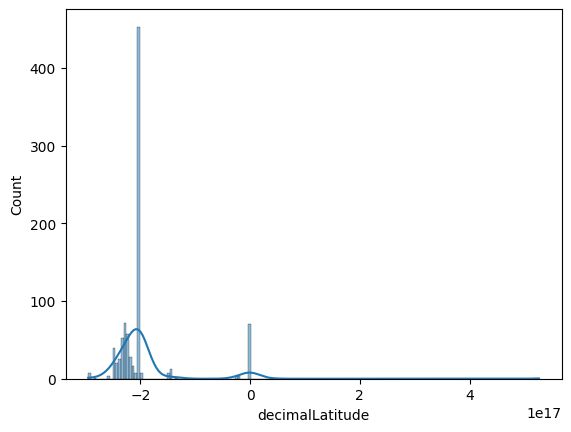

In [114]:
#Verificação da distribuição das features
grafico_dist_1 = sns.histplot(dataset_utilizavel["decimalLatitude"],  kde=True)


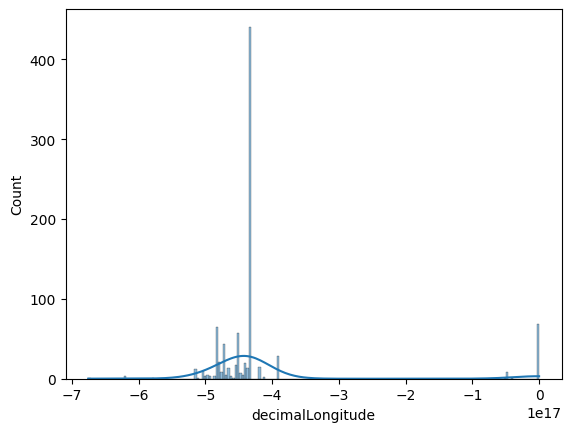

In [111]:
grafico_dist_2 = sns.histplot(dataset_utilizavel["decimalLongitude"],  kde=True)

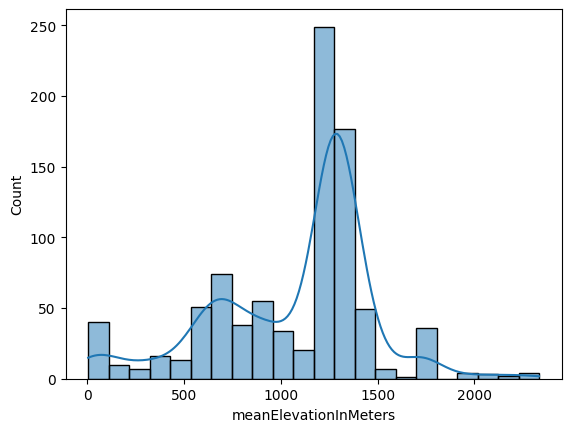

In [112]:
grafico_dist_3 = sns.histplot(dataset_utilizavel["meanElevationInMeters"],  kde=True)

#### Referências:

[1]. CASSAR, Daniel. "ATP-203 7.0 - Dados sintéticos e pipeline.ipynb" [Material de sala de aula]. Aprendizado de Máquina, 23 de setembro de 2024, Ilum - Escola de Ciência.

[2]. AWAN, A. Naive Bayes Classifier Tutorial: with Python Scikit-learn. Disponível em: <https://www.datacamp.com/tutorial/naive-bayes-scikit-learn>.

[3]. ESCOVEDO, T. Trabalhando com classes desbalanceadas em problemas Machine Learning. Disponível em: <https://tatianaesc.medium.com/trabalhando-com-classes-desbalanceadas-em-problemas-machine-learning-29ee8db4a049>. Acesso em: 10 nov. 2024.

[4]. CASSAR, Daniel. "ATP-203 3.0 - Modelo linear e baseline.ipynb" [Material de sala de aula]. Aprendizado de Máquina, 19 de setembro de 2024, Ilum - Escola de Ciência.

[5]. CASSAR, Daniel. "ATP-203 4.0 - Split de dados de treino e teste.ipynb" [Material de sala de aula]. Aprendizado de Máquina, 19 de setembro de 2024, Ilum - Escola de Ciência.

[6]. SCIKIT-LEARN. 1.9. Naive Bayes — scikit-learn 0.21.3 documentation. Disponível em: <https://scikit-learn.org/stable/modules/naive_bayes.html>.

[5]. CASSAR, Daniel. "LMA-203 7.1 - Distribuições de probabilidades contínuas" [Material de sala de aula]. Aprendizado de Máquina, 26 de setembro de 2024, Ilum - Escola de Ciência.